In [50]:
from astropy.table import Table, join
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Distance
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

from utils import *

mpl.rcParams.update({'font.size': 45, 
							'font.family': 'STIXGeneral', 
							'mathtext.fontset': 'stix',
							'xtick.labelsize':18,
							'ytick.labelsize':18,
							'xtick.major.width':2,
							'ytick.major.width':2,
							'axes.linewidth':2,
							'lines.linewidth':3,
							'legend.fontsize':18})

%matplotlib inline

In [187]:
# Read in clump data and SE catalog

sdss = Table.read('../data/final_clumpy_sample_DR12ancillary_highzgal.csv')
sdss['survey_id'] = sdss['OBJID']
sex1 = Table.read('../data/SEcatalog_faint.csv')

data = join(sdss, sex1, keys='survey_id')

# Read in spectra data
gzdata = Table.read("../data/2017-01-30_final_clumpy_sample.csv")

data = join(data, gzdata, keys='survey_id')

# Read in the spectra lookup table
spectable = Table.read('../data/2017-01-30_object_spectra_lookup_table.csv')


In [188]:
spectable

OBJID,DR12objid,RA,DEC,ra2,dec2,specObjID,plate,mjd,fiberID,z,zErr
int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64
8647474690313946727,1237656567038608395,313.1226,-1.072714,313.1226,-1.0727334,1106819297918871552,983,52443,217,0.05495704,4.064313e-05
8647474690329084045,1237663275774902499,347.6749,-1.163527,347.67491,-1.1634723,428991534390601728,381,51811,86,0.01234631,4.717897e-06
8647474690334458050,1237663275780276407,0.01344961,-1.113013,0.013429198,-1.1130411,771305244821841920,685,52203,232,0.02177868,5.148592e-06
8647474690339438846,1237663782591791113,11.38851,-1.105878,11.39023,-1.10353,1221616009916475392,1085,52531,53,0.01366896,5.746615e-06
8647474690339438846,1237663782591791110,11.38851,-1.105878,11.391259,-1.1017326,778030682503931904,691,52199,123,0.01377012,3.565432e-06
8647474690339438846,1237663782591791116,11.38851,-1.105878,11.395839,-1.104012,1683235528406755328,1495,52944,55,0.01372564,7.528681e-06
8647474690343043368,1237663782595330352,19.51202,-1.166398,19.512057,-1.166392,1216028842972440576,1080,52614,207,0.03989848,1.09604e-05
8647474690344747089,1237663782597034032,23.42248,-1.158285,23.42261,-1.158271,1213781441691805696,1078,52643,223,0.0164872,5.687107e-06
8647474690344747089,1237663782597034029,23.42248,-1.158285,23.421757,-1.158842,1691162470858647552,1502,53741,221,0.01635964,2.641237e-06


In [182]:
#print specdata.colnames
#print
print spectable.colnames
print len(spectable)
print data.colnames

['OBJID', 'DR12objid', 'RA', 'DEC', 'ra2', 'dec2', 'specObjID', 'plate', 'mjd', 'fiberID', 'z', 'zErr']
171
['OBJID', 'DR12objid_1', 'RA_1', 'DEC_1', 'petroMag_u_1', 'petroMag_g_1', 'petroMag_r_1', 'petroMag_i_1', 'petroMag_z_1', 'petroMagErr_u_1', 'petroMagErr_g_1', 'petroMagErr_r_1', 'petroMagErr_i_1', 'petroMagErr_z_1', 'extinction_u_1', 'extinction_g_1', 'extinction_r_1', 'extinction_i_1', 'extinction_z_1', 'petroFlux_u', 'petroFlux_g', 'petroFlux_r', 'petroFlux_i', 'petroFlux_z', 'petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'petroRad_z', 'petroRadErr_u', 'petroRadErr_g', 'petroRadErr_r', 'petroRadErr_i', 'petroRadErr_z', 'petroR50_u', 'petror50_g', 'petror50_r', 'petror50_i_1', 'petror50_z', 'petroR90_u', 'petror90_g', 'petror90_r', 'petror90_i', 'petror90_z', 'survey_id', 'NUMBER', 'FLUX_AUTO', 'FLUXERR_AUTO', 'MAG_AUTO', 'MAGERR_AUTO', 'FLUX_PETRO', 'FLUXERR_PETRO', 'MAG_PETRO', 'MAGERR_PETRO', 'KRON_RADIUS', 'PETRO_RADIUS', 'BACKGROUND', 'THRESHOLD', 'ISOAREA_IMAGE',

In [183]:
# Isolate those that I've visually identified as poor segmaps 
problem_gals = [0, 5, 8, 13, 15, 29, 39, 46, 55, 
                66, 76, 71, 77, 86, 87, 90, 92, 101]
good = np.ones_like(sdss['petroMag_r'], dtype=bool)
good[problem_gals] = False

In [194]:
# Define a simple cosmology to get physical distances
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

spectable['clump_dist'] = np.zeros(len(spectable))
spectable['norm_clump_dist'] = np.zeros(len(spectable))

# For each galaxy in our sample
for gal in data[good]:
    # Determine how many spectra it has
    numspec = gal['num_spec']

    specmask = spectable['OBJID']==gal['OBJID']
    spectra = spectable[specmask]
    
    center = SkyCoord(gal['X_WORLD']*u.deg, gal['Y_WORLD']*u.deg)
    
    # ------ Get the Petrosian radius of the galaxy ["] 
    # Note: SE's petro_rad is in "units" of A_IMAGE which is in pixels --
    #   convert to arcsecond through the pixel scale of image: 0.396 "/pixel
    petro_rad_arcs = gal['PETRO_RADIUS']*gal['A_IMAGE']*0.396*u.arcsecond   
    
    # ------ Get the Half-light radius 
    # Note: SE's flux radius is in pixel units
    half_rad_arcs = gal['FLUX_RADIUS']*0.396*u.arcsecond
    
    # ------ Compute the physical scale from angular diameter distance [kpc/"] 
    # Note 1: D_A is computed in units of Mpc -- convert to kpc
    # Note 2: D_A is based on subtended angle in units of radians -- convert to arcseconds
    scale = cosmo.angular_diameter_distance(gal['z_avg']).to(u.kpc)/(206264.67*u.arcsecond)
    
    # Convert Petrosian radius ["] to [kpc] 
    half_rad_kpc = half_rad_arcs*scale
    
    for spec in spectra:

        clump = SkyCoord(spec['ra2']*u.deg, spec['dec2']*u.deg)
        
        # Compute the clump distance in arcseconds 
        # Then multiply by the scale to convert to kpc 
        clump_distance =  center.separation(clump).arcsecond*u.arcsecond*scale

        # Normalize by the petrosian radius of the galaxy 
        norm_clump_dist = clump_distance/half_rad_kpc
        
        loc = np.where(spectable['specObjID']==spec['specObjID'])[0][0]
        spectable[loc]['clump_dist'] = clump_distance.value
        spectable[loc]['norm_clump_dist'] = norm_clump_dist

### Looks like we have 26 spectra with no distances yet
This is expected because I have excluded those galaxies which I marked as "bad"

In [205]:
print np.sum(spectable['clump_dist']==0.)

# Save our distances
spectable.write('../data/2017-01-30_object_spectra_lookup_table.csv', overwrite=True)

26


# Plot their distribution

2.58843555913
0.911423623886


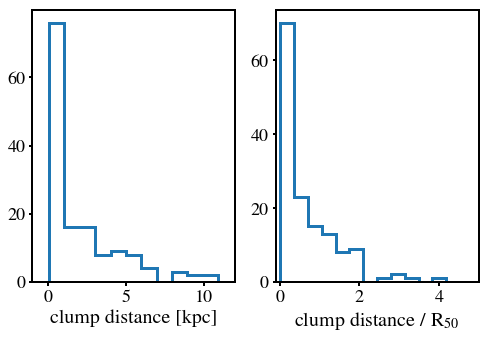

In [198]:
def fd(data):
    w = 2.*np.subtract(*np.percentile(data, (75,25)))/len(data)**(1./3.)
    print np.subtract(*np.percentile(data, (75,25)))
    return np.arange(np.min(data), np.max(data)+w, w)


fig = plt.figure(figsize=(8,5))

dist = spectable['clump_dist'][spectable['clump_dist']>0.]

ax = fig.add_subplot(121)
ax.hist(dist, bins=fd(dist), histtype='step',lw=3)
ax.set_xlim(-1, 12)
ax.set_xlabel("clump distance [kpc]", fontsize=20)

norm_dist = spectable['norm_clump_dist'][spectable['norm_clump_dist']>0.]

ax = fig.add_subplot(122)
ax.hist(norm_dist, bins=fd(norm_dist), histtype='step',lw=3)
ax.set_xlim(-0.1, 5)
ax.set_xlabel(r"clump distance / R$_{50}$", fontsize=20)

# Bottom line: I probably don't care about these two spectra
These are mega-outliers that probably aren't worth our time to recover

In [200]:
spectable[spectable['norm_clump_dist'] >5]

OBJID,DR12objid,RA,DEC,ra2,dec2,specObjID,plate,mjd,fiberID,z,zErr,clump_dist,norm_clump_dist
int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64
8647474690334458050,1237663275780276407,0.01344961,-1.113013,0.013429198,-1.1130411,771305244821841920,685,52203,232,0.02177868,5.148592e-06,26.8662838367,23.3032625805
587731186742722714,1237657191444054059,4.475896,0.3292831,4.4808229,0.33523211,773646385240107008,687,52518,557,0.01808284,1.301776e-05,9.46604000035,6.08520335632


In [201]:
# THIS ONE HAS FUCKED UP WCS-- X_WORLD IS COMPLETELY WRONG
data[data['OBJID'] == 8647474690334458050]

OBJID,DR12objid_1,RA_1,DEC_1,petroMag_u_1,petroMag_g_1,petroMag_r_1,petroMag_i_1,petroMag_z_1,petroMagErr_u_1,petroMagErr_g_1,petroMagErr_r_1,petroMagErr_i_1,petroMagErr_z_1,extinction_u_1,extinction_g_1,extinction_r_1,extinction_i_1,extinction_z_1,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroRad_u,petroRad_g,petroRad_r,petroRad_i,petroRad_z,petroRadErr_u,petroRadErr_g,petroRadErr_r,petroRadErr_i,petroRadErr_z,petroR50_u,petror50_g,petror50_r,petror50_i_1,petror50_z,petroR90_u,petror90_g,petror90_r,petror90_i,petror90_z,survey_id,NUMBER,FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,FLUX_PETRO,FLUXERR_PETRO,MAG_PETRO,MAGERR_PETRO,KRON_RADIUS,PETRO_RADIUS,BACKGROUND,THRESHOLD,ISOAREA_IMAGE,X_IMAGE,Y_IMAGE,X_WORLD,Y_WORLD,A_IMAGE,B_IMAGE,THETA_IMAGE,ELONGATION,ELLIPTICITY,FLUX_RADIUS,pogson,asinh,AB,zooniverse_id,Table,DR7objid,DR12objid_2,RA_2,DEC_2,imaging,total_count,total_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_flag,t01_smooth_or_features_total_count,t01_smooth_or_features_total_weight,t02_edgeon_a01_yes_fraction,t02_edgeon_a01_yes_weighted_fraction,t02_edgeon_a02_no_fraction,t02_edgeon_a02_no_weighted_fraction,t02_edgeon_total_count,t02_edgeon_total_weight,t03_bar_a01_bar_fraction,t03_bar_a01_bar_weighted_fraction,t03_bar_a02_no_bar_fraction,t03_bar_a02_no_bar_weighted_fraction,t03_bar_total_count,t03_bar_total_weight,t04_spiral_a01_spiral_fraction,t04_spiral_a01_spiral_weighted_fraction,t04_spiral_a02_no_spiral_fraction,t04_spiral_a02_no_spiral_weighted_fraction,t04_spiral_total_count,t04_spiral_total_weight,t05_bulge_prominence_a01_no_bulge_fraction,t05_bulge_prominence_a01_no_bulge_weighted_fraction,t05_bulge_prominence_a02_just_noticeable_fraction,t05_bulge_prominence_a02_just_noticeable_weighted_fraction,t05_bulge_prominence_a03_obvious_fraction,t05_bulge_prominence_a03_obvious_weighted_fraction,t05_bulge_prominence_a04_dominant_fraction,t05_bulge_prominence_a04_dominant_weighted_fraction,t05_bulge_prominence_total_count,t05_bulge_prominence_total_weight,t06_odd_a01_yes_fraction,t06_odd_a01_yes_weighted_fraction,t06_odd_a02_no_fraction,t06_odd_a02_no_weighted_fraction,t06_odd_total_count,t06_odd_total_weight,t07_rounded_a01_completely_round_fraction,t07_rounded_a01_completely_round_weighted_fraction,t07_rounded_a02_in_between_fraction,t07_rounded_a02_in_between_weighted_fraction,t07_rounded_a03_cigar_shaped_fraction,t07_rounded_a03_cigar_shaped_weighted_fraction,t07_rounded_total_count,t07_rounded_total_weight,t08_odd_feature_a01_ring_fraction,t08_odd_feature_a01_ring_weighted_fraction,t08_odd_feature_a02_lens_or_arc_fraction,t08_odd_feature_a02_lens_or_arc_weighted_fraction,t08_odd_feature_a03_disturbed_fraction,t08_odd_feature_a03_disturbed_weighted_fraction,t08_odd_feature_a04_irregular_fraction,t08_odd_feature_a04_irregular_weighted_fraction,t08_odd_feature_a05_other_fraction,t08_odd_feature_a05_other_weighted_fraction,t08_odd_feature_a06_merger_fraction,t08_odd_feature_a06_merger_weighted_fraction,t08_odd_feature_a07_dust_lane_fraction,t08_odd_feature_a07_dust_lane_weighted_fraction,t08_odd_feature_total_count,t08_odd_feature_total_weight,t09_bulge_shape_a01_rounded_fraction,t09_bulge_shape_a01_rounded_weighted_fraction,t09_bulge_shape_a02_boxy_fraction,t09_bulge_shape_a02_boxy_weighted_fraction,t09_bulge_shape_a03_no_bulge_fraction,t09_bulge_shape_a03_no_bulge_weighted_fraction,t09_bulge_shape_total_count,t09_bulge_shape_total_weight,t10_arms_winding_a01_tight_fraction,t10_arms_winding_a01_tight_weighted_fraction,t10_arms_winding_a02_medium_fraction,t10_arms_winding_a02_medium_wei

In [174]:
5.28*6.31
5.28*4.4

23.232000000000003

In [177]:
# THIS ONE IS THE WRONG SPECTRUM! 
# This little guy is an offshoot of a bigger, spiral galaxy and the spectrum
# I have is for the center of the bigger spiral galaxy. 
data[data['OBJID'] == 587731186742722714]

OBJID,DR12objid_1,RA_1,DEC_1,petroMag_u_1,petroMag_g_1,petroMag_r_1,petroMag_i_1,petroMag_z_1,petroMagErr_u_1,petroMagErr_g_1,petroMagErr_r_1,petroMagErr_i_1,petroMagErr_z_1,extinction_u_1,extinction_g_1,extinction_r_1,extinction_i_1,extinction_z_1,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroRad_u,petroRad_g,petroRad_r,petroRad_i,petroRad_z,petroRadErr_u,petroRadErr_g,petroRadErr_r,petroRadErr_i,petroRadErr_z,petroR50_u,petror50_g,petror50_r,petror50_i_1,petror50_z,petroR90_u,petror90_g,petror90_r,petror90_i,petror90_z,survey_id,NUMBER,FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,FLUX_PETRO,FLUXERR_PETRO,MAG_PETRO,MAGERR_PETRO,KRON_RADIUS,PETRO_RADIUS,BACKGROUND,THRESHOLD,ISOAREA_IMAGE,X_IMAGE,Y_IMAGE,X_WORLD,Y_WORLD,A_IMAGE,B_IMAGE,THETA_IMAGE,ELONGATION,ELLIPTICITY,pogson,asinh,AB,zooniverse_id,Table,DR7objid,DR12objid_2,RA_2,DEC_2,imaging,total_count,total_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_flag,t01_smooth_or_features_total_count,t01_smooth_or_features_total_weight,t02_edgeon_a01_yes_fraction,t02_edgeon_a01_yes_weighted_fraction,t02_edgeon_a02_no_fraction,t02_edgeon_a02_no_weighted_fraction,t02_edgeon_total_count,t02_edgeon_total_weight,t03_bar_a01_bar_fraction,t03_bar_a01_bar_weighted_fraction,t03_bar_a02_no_bar_fraction,t03_bar_a02_no_bar_weighted_fraction,t03_bar_total_count,t03_bar_total_weight,t04_spiral_a01_spiral_fraction,t04_spiral_a01_spiral_weighted_fraction,t04_spiral_a02_no_spiral_fraction,t04_spiral_a02_no_spiral_weighted_fraction,t04_spiral_total_count,t04_spiral_total_weight,t05_bulge_prominence_a01_no_bulge_fraction,t05_bulge_prominence_a01_no_bulge_weighted_fraction,t05_bulge_prominence_a02_just_noticeable_fraction,t05_bulge_prominence_a02_just_noticeable_weighted_fraction,t05_bulge_prominence_a03_obvious_fraction,t05_bulge_prominence_a03_obvious_weighted_fraction,t05_bulge_prominence_a04_dominant_fraction,t05_bulge_prominence_a04_dominant_weighted_fraction,t05_bulge_prominence_total_count,t05_bulge_prominence_total_weight,t06_odd_a01_yes_fraction,t06_odd_a01_yes_weighted_fraction,t06_odd_a02_no_fraction,t06_odd_a02_no_weighted_fraction,t06_odd_total_count,t06_odd_total_weight,t07_rounded_a01_completely_round_fraction,t07_rounded_a01_completely_round_weighted_fraction,t07_rounded_a02_in_between_fraction,t07_rounded_a02_in_between_weighted_fraction,t07_rounded_a03_cigar_shaped_fraction,t07_rounded_a03_cigar_shaped_weighted_fraction,t07_rounded_total_count,t07_rounded_total_weight,t08_odd_feature_a01_ring_fraction,t08_odd_feature_a01_ring_weighted_fraction,t08_odd_feature_a02_lens_or_arc_fraction,t08_odd_feature_a02_lens_or_arc_weighted_fraction,t08_odd_feature_a03_disturbed_fraction,t08_odd_feature_a03_disturbed_weighted_fraction,t08_odd_feature_a04_irregular_fraction,t08_odd_feature_a04_irregular_weighted_fraction,t08_odd_feature_a05_other_fraction,t08_odd_feature_a05_other_weighted_fraction,t08_odd_feature_a06_merger_fraction,t08_odd_feature_a06_merger_weighted_fraction,t08_odd_feature_a07_dust_lane_fraction,t08_odd_feature_a07_dust_lane_weighted_fraction,t08_odd_feature_total_count,t08_odd_feature_total_weight,t09_bulge_shape_a01_rounded_fraction,t09_bulge_shape_a01_rounded_weighted_fraction,t09_bulge_shape_a02_boxy_fraction,t09_bulge_shape_a02_boxy_weighted_fraction,t09_bulge_shape_a03_no_bulge_fraction,t09_bulge_shape_a03_no_bulge_weighted_fraction,t09_bulge_shape_total_count,t09_bulge_shape_total_weight,t10_arms_winding_a01_tight_fraction,t10_arms_winding_a01_tight_weighted_fraction,t10_arms_winding_a02_medium_fraction,t10_arms_winding_a02_medium_weighted_fracti

# Let's see how the distance compares with H$\alpha$

In [208]:
# Read in emission line catalog
emission = Table.read('../data/2017-01-30_emission_line_catalog.csv')

In [221]:
goodspec = (emission['norm_clump_dist']>0) & (emission['norm_clump_dist'] < 5)


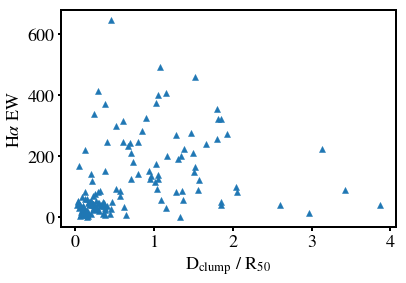

In [219]:
plt.scatter(emission[goodspec]['norm_clump_dist'], 
            emission[goodspec]['Ha_LINEEW'], marker='^')
plt.xlabel(r'D$_{\mathrm{clump}}$ / R$_{50}$', fontsize=18)
plt.ylabel(r'H$\alpha$ EW', fontsize=18)

In [ ]:
# Correct Halpha EW for z 

In [ ]:
# Confirm that clump distances make sense compared to galaxy centers
# Are their AGN?
# Color-code by gal color b-v, for example
# What's with the low Ha-large clump distance? Mergers? 


# Composite-model templates? (old+young components)